<a href="https://colab.research.google.com/github/fastdatascience/clinical_trial_risk/blob/fixes_nov_2022/train/ctgov/TrainNumCountriesClassifier_14_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_annotations = pd.read_csv("/content/drive/MyDrive/data/all_annotations.csv")


# Get data

In [4]:
with open("/content/drive/MyDrive/data/protocols.pkl.gz", "rb") as f:
    file_to_pages = pkl.load(f)

In [5]:
texts = []

for i in range(len(df_annotations)):
    file_name = df_annotations.file.iloc[i]
    
    pages= file_to_pages[file_name]
    # Limit to first 3 pages because of memory constraints
    if len(pages) > 3:
      pages = pages[:3]

    texts.append(" ".join(pages))
df_annotations["text"] = texts

In [6]:
def get_num_countries(x):
  if x is not None and type(x) is str:
    return len(x.split(","))
  return None

In [7]:
df_annotations["num_countries"] = df_annotations.country.apply(get_num_countries)

In [8]:
df_annotations["num_countries"].value_counts()

1.0     7998
2.0      726
3.0      341
4.0      263
5.0      230
6.0      225
7.0      193
8.0      176
10.0     155
9.0      137
11.0     135
12.0     116
13.0     109
14.0      92
15.0      90
17.0      78
18.0      68
16.0      65
21.0      57
20.0      56
19.0      54
23.0      47
22.0      44
24.0      35
25.0      31
26.0      27
29.0      22
30.0      21
27.0      20
31.0      19
28.0      18
32.0      17
33.0      14
41.0      11
34.0      11
38.0       8
39.0       8
37.0       7
43.0       7
36.0       6
35.0       6
44.0       6
40.0       6
48.0       6
47.0       3
42.0       2
49.0       2
50.0       2
45.0       1
58.0       1
46.0       1
62.0       1
51.0       1
54.0       1
Name: num_countries, dtype: int64

In [9]:
def get_is_international(num):
    if num is None or pd.isna(num):
      return None
    if num >= 2:
      return 1
    return 0
df_annotations["is_international"] = df_annotations["num_countries"].apply(get_is_international)

In [10]:
df_annotations["is_international"].value_counts()

0.0    7998
1.0    3778
Name: is_international, dtype: int64

# Train and evaluate the number of countries extractor

In [11]:
df_train = df_annotations[(df_annotations.train_val == "train") & (~df_annotations.is_international.isna())]

In [12]:
df_train_to_augment = df_train[df_train.is_international == 1]

In [13]:
df_train_augmented = df_train # pd.concat([df_train, df_train_to_augment])

In [14]:
df_train_augmented["is_international"].value_counts()

0.0    6375
1.0    3052
Name: is_international, dtype: int64

In [15]:
df_val = df_annotations[df_annotations.train_val == "val"]

# Begin Keras

In [16]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.9.2
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [17]:
train_labels = np.asarray(list(df_train[~df_train.is_international.isna()].num_countries))
test_labels = np.asarray(list(df_val.num_countries))

In [18]:
train_examples = np.asarray(list(df_train[~df_train.is_international.isna()].text))
test_examples = np.asarray(list(df_val.text))

In [19]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 1.3878716 ,  0.22550987,  0.7648921 , -0.08218446,  1.3620344 ,
        -1.0987713 , -1.0985049 ,  0.20052177,  0.05066561,  0.04839747,
         0.28400636, -0.42893174, -0.16622992, -0.59827983,  0.60503167,
         0.23048669,  1.8119524 , -0.84469086, -0.19094974,  0.94411767,
         0.3425336 ,  0.33559614,  0.5701396 , -0.7833848 , -0.12382686,
        -1.7660372 ,  0.93029356,  1.142028  , -0.48254454, -0.482065  ,
         0.6241091 ,  0.84202796, -1.6181043 ,  0.17544147,  1.1464902 ,
        -0.80830246,  0.6926952 , -0.12133206, -0.30814207,  0.72136027,
        -0.08131983, -0.43965235, -0.01713948, -0.00602878, -0.4521674 ,
         0.19415072, -0.06903778,  0.3778937 , -0.5719413 ,  0.6060289 ],
       [ 2.5179925 , -0.05013091,  0.48261794,  0.9314328 ,  1.1721319 ,
        -0.17170158, -0.916963  ,  0.5768889 , -0.11765438,  0.5758045 ,
        -0.8817778 ,  0.07264417,  0.09085304, -0.8050936 ,  0.6701702 ,
 

In [20]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer='adam',
              loss=tf.losses.MeanSquaredError(),
              metrics=[tf.metrics.RootMeanSquaredError(name='mse'), tf.metrics.MeanAbsoluteError(name='mae')],
              run_eagerly=True)

In [22]:
# x_val = train_examples[:10000]
# partial_x_train = train_examples[10000:]

# y_val = train_labels[:10000]
# partial_y_train = train_labels[10000:]

partial_x_train = train_examples
x_val = test_examples

partial_y_train = train_labels
y_val = test_labels

In [23]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=100,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/100
19/19 [==============================] - 4s 81ms/step - loss: 53.6079 - mse: 7.3217 - mae: 3.6253 - val_loss: nan - val_mse: nan - val_mae: nan
Epoch 2/100
19/19 [==============================] - 1s 76ms/step - loss: 44.0858 - mse: 6.6397 - mae: 4.0487 - val_loss: nan - val_mse: nan - val_mae: nan
Epoch 3/100
19/19 [==============================] - 1s 74ms/step - loss: 39.9636 - mse: 6.3217 - mae: 3.7318 - val_loss: nan - val_mse: nan - val_mae: nan
Epoch 4/100
19/19 [==============================] - 1s 75ms/step - loss: 36.2086 - mse: 6.0174 - mae: 3.4601 - val_loss: nan - val_mse: nan - val_mae: nan
Epoch 5/100
19/19 [==============================] - 1s 75ms/step - loss: 32.9485 - mse: 5.7401 - mae: 3.2796 - val_loss: nan - val_mse: nan - val_mae: nan
Epoch 6/100
19/19 [==============================] - 1s 76ms/step - loss: 30.2477 - mse: 5.4998 - mae: 3.1561 - val_loss: nan - val_mse: nan - val_mae: nan
Epoch 7/100
19/19 [==============================] - 1s 76ms/ste

In [24]:
model.save('num_countries_model_14_keras.keras')

In [25]:
model.save('/content/drive/MyDrive/data/num_countries_model_14_keras')

SyntaxError: ignored

In [26]:
results = model.evaluate(test_examples, test_labels)

print(results)

34/34 [==============================] - 0s 12ms/step - loss: nan - mse: nan - mae: nan
[nan, nan, nan]


In [27]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])

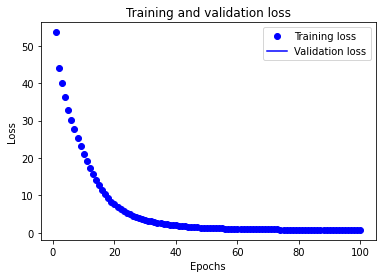

In [28]:
acc = history_dict['mae']
val_acc = history_dict['val_mae']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

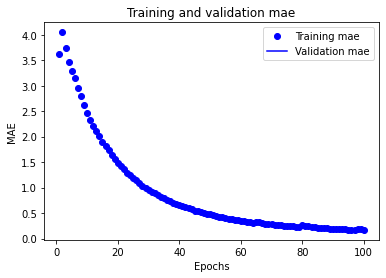

In [29]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training mae')
plt.plot(epochs, val_acc, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

In [30]:
input_texts= np.asarray(df_val.text)

In [31]:
pred_proba = model.predict(input_texts)

34/34 [==============================] - 0s 5ms/step


In [32]:
df_val["pred_regression"] = pred_proba

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
df_val["pred_international"] = df_val["pred_regression"].apply(lambda x : str(int(x > 1.5)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
pred_international = df_val["pred_international"]

In [35]:
is_international_ground_truths = df_val.is_international.apply(str).apply(lambda x : re.sub(r'\.0', '', x))

In [36]:
acc = accuracy_score(is_international_ground_truths.apply(str), pred_international.apply(str))
print (f"Num countries accuracy {acc}")

Num countries accuracy 0.6092165898617512


''

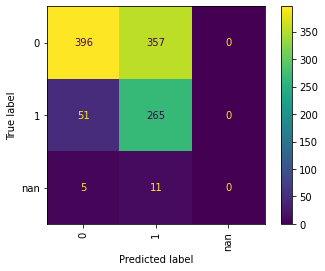

In [37]:
ConfusionMatrixDisplay.from_predictions(is_international_ground_truths.apply(str), pred_international.apply(str))
plt.xticks(rotation=90)
;

In [40]:
mean_absolute_error(df_val[~df_val.num_countries.isna()].num_countries, df_val[~df_val.num_countries.isna()]["pred_regression"])

3.462836944507705

In [43]:
np.sqrt(mean_squared_error(df_val[~df_val.num_countries.isna()].num_countries, df_val[~df_val.num_countries.isna()]["pred_regression"]))

8.412106914587149

(0.0, 20.0)

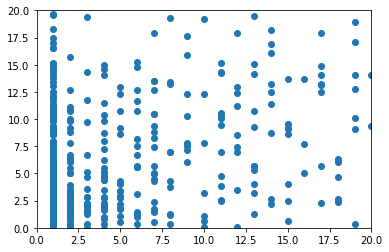

In [49]:
plt.scatter(df_val[~df_val.num_countries.isna()].num_countries, df_val[~df_val.num_countries.isna()]["pred_regression"])
plt.xlim(0,20)
plt.ylim(0,20)

In [54]:
from sklearn.metrics import r2_score

In [56]:
r2_score(df_val[~df_val.num_countries.isna()].num_countries, df_val[~df_val.num_countries.isna()]["pred_regression"])

-0.6685765438762818

(array([196., 159.,  67.,  46.,  30.,  20.,  19.,  17.,  26.,  22.,  21.,
          9.,  16.,  18.,  17.,   4.,   5.,   6.,   4.,   6.]),
 array([ 1.  ,  1.95,  2.9 ,  3.85,  4.8 ,  5.75,  6.7 ,  7.65,  8.6 ,
         9.55, 10.5 , 11.45, 12.4 , 13.35, 14.3 , 15.25, 16.2 , 17.15,
        18.1 , 19.05, 20.  ], dtype=float32),
 <a list of 20 Patch objects>)

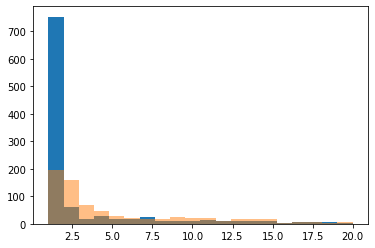

In [53]:
plt.hist(df_val[~df_val.num_countries.isna()].num_countries, range=(1,20), bins=20)
plt.hist(df_val[~df_val.num_countries.isna()].pred_regression, range=(1,20), bins=20, alpha=0.5)

In [46]:
for i in range(len(df_val[~df_val.num_countries.isna()])):
  print (df_val[~df_val.num_countries.isna()].num_countries.iloc[i], df_val[~df_val.num_countries.isna()]["pred_regression"].iloc[i])

22.0 21.144125
1.0 1.8796475
1.0 4.223917
6.0 15.239582
1.0 10.874343
1.0 -1.1959716
1.0 4.5929613
17.0 2.2989395
1.0 0.6496595
1.0 -0.74729455
21.0 10.153323
1.0 -0.0842831
1.0 2.3313987
1.0 -0.22967193
1.0 0.99914694
1.0 3.2761035
1.0 0.40317482
1.0 7.723652
1.0 2.8521707
1.0 -1.021039
1.0 2.4925468
2.0 5.457601
1.0 1.4032584
12.0 0.037156105
6.0 1.289045
1.0 0.60035133
1.0 4.0504756
6.0 3.0634935
1.0 0.6418456
1.0 10.998809
1.0 6.8886
1.0 4.704488
1.0 1.1700401
1.0 2.0907915
1.0 1.566643
11.0 9.43213
1.0 1.1057999
14.0 16.07409
1.0 0.40246895
1.0 2.4221933
1.0 -0.011498421
1.0 7.699995
1.0 1.9557316
7.0 10.459925
1.0 1.4388117
1.0 1.1575816
1.0 -0.12041521
1.0 14.658831
1.0 2.6147068
1.0 1.2152901
1.0 -0.24174365
1.0 1.8029948
1.0 2.7188668
1.0 1.5080478
2.0 0.1302652
21.0 18.729548
6.0 1.4879895
37.0 1.9562467
1.0 1.8720186
3.0 1.2661413
1.0 -3.240828
1.0 2.51846
1.0 1.9674263
1.0 9.333852
3.0 5.1156034
1.0 1.1880924
1.0 3.587395
1.0 1.5632093
1.0 1.6532141
14.0 18.212994
1.0 2.672